# Uncovering Solar Cycles: Fourier Analysis of Daily Sunspot Numbers (1850–2025)

### Dataset Link: https://www.opendatabay.com/data/ai-ml/8153062a-3633-44b6-b126-89b0a3862ec3

### SILSO Link: https://www.sidc.be/SILSO/home

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make plots a bit bigger
plt.rcParams['figure.figsize'] = (10, 4)

# 1. Load the CSV
path = "daily_sunspots_time_series_1850-01_2025-01.csv"
df = pd.read_csv(path)

# 2. Inspect the structure
print(df.columns)
print(df.head())

Index(['date', 'year', 'month', 'day', 'date_frac', 'counts', 'std', 'nobs',
       'indicator'],
      dtype='object')
         date  year  month  day  date_frac  counts   std  nobs indicator
0  1850-01-01  1850      1    1   1850.001     253  19.6     1       NaN
1  1850-01-02  1850      1    2   1850.004     162  15.5     1       NaN
2  1850-01-03  1850      1    3   1850.007     217  18.1     1       NaN
3  1850-01-04  1850      1    4   1850.010      99  12.0     1       NaN
4  1850-01-05  1850      1    5   1850.012     108  12.6     1       NaN


### # Step 1: parse date, sort, and create daily sunspot time series

In [2]:
# Step 1: parse date, sort, and create daily sunspot time series
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

ts_daily = df.set_index('date')['counts'].astype(float)

print(ts_daily.head(), "\n")
print(ts_daily.tail())
print("Number of daily points:", len(ts_daily))


date
1850-01-01    253.0
1850-01-02    162.0
1850-01-03    217.0
1850-01-04     99.0
1850-01-05    108.0
Name: counts, dtype: float64 

date
2025-01-27     54.0
2025-01-28     75.0
2025-01-29     82.0
2025-01-30    106.0
2025-01-31    146.0
Name: counts, dtype: float64
Number of daily points: 63949


### # Step 2: Resample from daily to monthly mean

In [3]:
# Step 2: Resample from daily to monthly mean
ts_monthly = ts_daily.resample("M").mean().dropna()

print(ts_monthly.head(), "\n")
print(ts_monthly.tail())
print("Number of monthly points:", len(ts_monthly))


date
1850-01-31    148.225806
1850-02-28    169.750000
1850-03-31    156.838710
1850-04-30     83.833333
1850-05-31    117.032258
Freq: ME, Name: counts, dtype: float64 

date
2024-09-30    141.100000
2024-10-31    166.387097
2024-11-30    152.466667
2024-12-31    154.516129
2025-01-31    137.000000
Freq: ME, Name: counts, dtype: float64
Number of monthly points: 2101


/var/folders/n4/8n2hpd_912g5cknmv3k37fjm0000gn/T/ipykernel_37138/3111112133.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_monthly = ts_daily.resample("M").mean().dropna()


### # Step 3: Plot the full monthly series

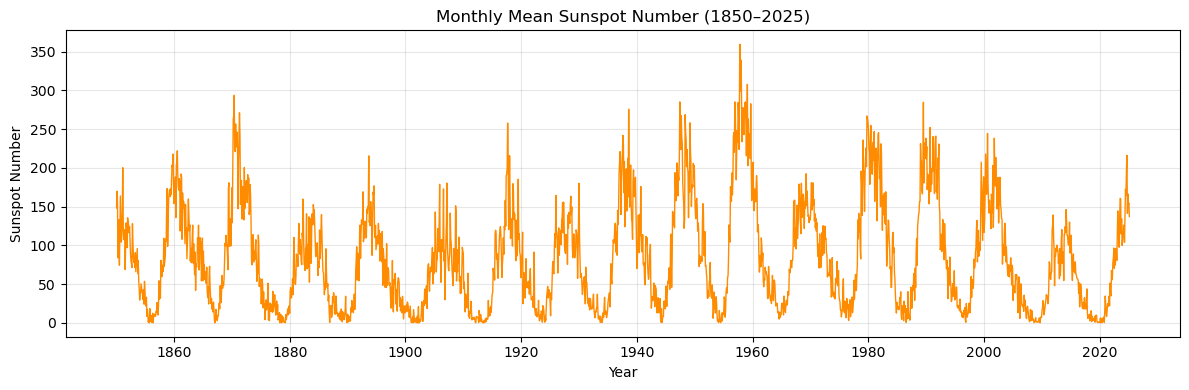

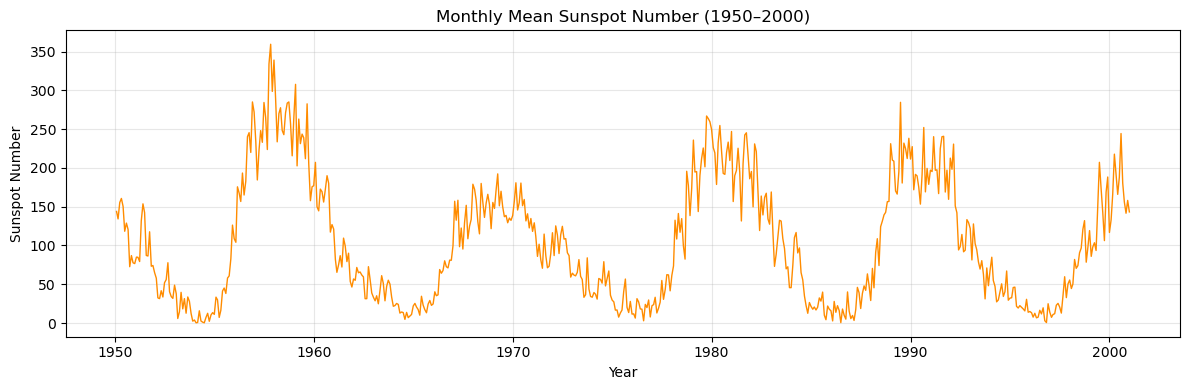

In [7]:
# Step 3: Plot the full monthly series

import matplotlib.pyplot as plt

solar_color = "#ff8c00"   # dark orange / sun-like

# ---------- Full period: 1850–2025 ----------
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(ts_monthly.index, ts_monthly.values, linewidth=1.0, color=solar_color)
ax.set_title("Monthly Mean Sunspot Number (1850–2025)")
ax.set_xlabel("Year")
ax.set_ylabel("Sunspot Number")
ax.grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig("sunspots_monthly_full_orange.png", dpi=600)

# ---------- Zoomed period: 1950–2000 ----------
zoom = ts_monthly["1950":"2000"]

fig2, ax2 = plt.subplots(figsize=(12, 4))
ax2.plot(zoom.index, zoom.values, linewidth=1.0, color=solar_color)
ax2.set_title("Monthly Mean Sunspot Number (1950–2000)")
ax2.set_xlabel("Year")
ax2.set_ylabel("Sunspot Number")
ax2.grid(True, alpha=0.3)

fig2.tight_layout()
fig2.savefig("sunspots_monthly_1950_2000_orange.png", dpi=600)

plt.show()

### # Step 4: Prepare data and compute FFT

In [8]:
import numpy as np

# Step 4: Prepare data and compute FFT

# 1. Convert monthly series to numpy array
x = ts_monthly.values.astype(float)

# 2. Basic info
N = len(x)          # number of samples
dt = 1.0            # sampling interval: 1 month between samples
fs = 1.0 / dt       # sampling frequency: 1 sample per month

print("Number of monthly samples N =", N)
print("Sampling interval dt =", dt, "month")
print("Sampling frequency fs =", fs, "samples per month")

# 3. Remove mean so DC component doesn't dominate
x_demean = x - x.mean()

# 4. Compute FFT
X = np.fft.fft(x_demean)

# 5. Frequency axis (in cycles per month)
freqs = np.fft.fftfreq(N, d=dt)

# 6. Keep only positive frequencies
positive = freqs > 0
freqs_pos = freqs[positive]
X_pos = X[positive]

# 7. Power spectrum
power = np.abs(X_pos) ** 2

print("Size of positive-frequency spectrum:", len(freqs_pos))


Number of monthly samples N = 2101
Sampling interval dt = 1.0 month
Sampling frequency fs = 1.0 samples per month
Size of positive-frequency spectrum: 1050


### # Step 5: Convert frequencies to periods (years) and plot power spectrum

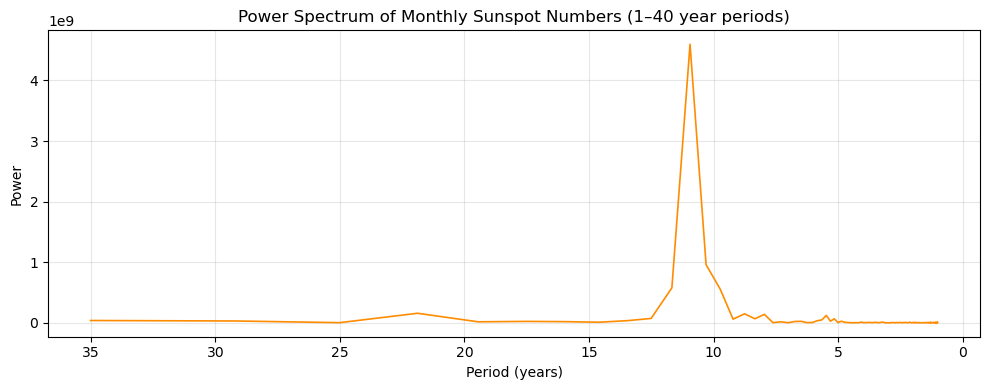

Min / max period shown (years): 1.0004761904761905 35.01666666666667
Number of frequency points plotted: 171


In [9]:
# Step 5: Convert frequencies to periods (years) and plot power spectrum

import matplotlib.pyplot as plt
import numpy as np

# 1. Convert from cycles per month to cycles per year
freqs_per_year = freqs_pos * 12.0              # cycles / year

# 2. Period in years = 1 / frequency
period_years = 1.0 / freqs_per_year

# 3. Keep only reasonable periods, e.g. 1–40 years
mask = (period_years >= 1) & (period_years <= 40)
period_plot = period_years[mask]
power_plot = power[mask]

# 4. Plot power vs period (years)
solar_color = "#ff8c00"   # orangish

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(period_plot, power_plot, color=solar_color, linewidth=1.2)
ax.set_xlabel("Period (years)")
ax.set_ylabel("Power")
ax.set_title("Power Spectrum of Monthly Sunspot Numbers (1–40 year periods)")
ax.grid(True, alpha=0.3)

# Put longer periods on the left (optional)
ax.invert_xaxis()

fig.tight_layout()
fig.savefig("sunspots_power_spectrum_1_40yrs_orange.png", dpi=700)

plt.show()

print("Min / max period shown (years):", period_plot.min(), period_plot.max())
print("Number of frequency points plotted:", len(period_plot))


### # Step 6: Find the strongest periodicities (top peaks) in the 1–40 year range

In [10]:
# Step 6: Find the strongest periodicities (top peaks) in the 1–40 year range

K = 10  # how many top periods to show

# Indices that would sort power_plot from largest to smallest
idx_sorted = np.argsort(power_plot)[::-1]
top_idx = idx_sorted[:K]

print(f"Top {K} periodicities in the 1–40 year range:\n")
for i in top_idx:
    period = period_plot[i]
    pwr = power_plot[i]
    print(f"  Period ≈ {period:6.2f} years   |   Power = {pwr: .3e}")


Top 10 periodicities in the 1–40 year range:

  Period ≈  10.94 years   |   Power =  4.597e+09
  Period ≈  10.30 years   |   Power =  9.600e+08
  Period ≈  11.67 years   |   Power =  5.766e+08
  Period ≈   9.73 years   |   Power =  5.518e+08
  Period ≈  21.89 years   |   Power =  1.571e+08
  Period ≈   8.75 years   |   Power =  1.481e+08
  Period ≈   7.96 years   |   Power =  1.389e+08
  Period ≈   5.47 years   |   Power =  1.216e+08
  Period ≈  12.51 years   |   Power =  7.193e+07
  Period ≈   8.34 years   |   Power =  6.648e+07


### # Step 7: Reconstruct the signal using the top K dominant frequencies

In [11]:
# Step 7: Reconstruct the signal using the top K dominant frequencies

import numpy as np
import pandas as pd

K = 10  # number of dominant frequencies to keep

# 1. Map from positive & 1–40 year mask back to indices in the full FFT array
pos_indices = np.where(positive)[0]            # indices of positive freqs in full X
freqs_per_year = freqs_pos * 12.0
period_years = 1.0 / freqs_per_year
mask_1_40 = (period_years >= 1) & (period_years <= 40)

use_indices = pos_indices[mask_1_40]          # full indices for 1–40 year band
power_1_40 = power[mask_1_40]

# 2. Find top-K by power within this band
idx_sorted = np.argsort(power_1_40)[::-1]
best_idx = use_indices[idx_sorted[:K]]

# 3. Build filtered spectrum: keep only those freqs (and their conjugates)
X_filtered = np.zeros_like(X, dtype=complex)

for k in best_idx:
    X_filtered[k] = X[k]
    X_filtered[-k] = X[-k]    # negative-frequency partner (complex conjugate)

# 4. Inverse FFT to reconstruct time series and add back the mean level
x_recon = np.fft.ifft(X_filtered).real + x.mean()

# 5. Put into a pandas Series aligned with the original monthly index
ts_recon = pd.Series(x_recon, index=ts_monthly.index)

print("Kept", K, "dominant frequencies.")
print("First 5 reconstructed values:")
print(ts_recon.head())


Kept 10 dominant frequencies.
First 5 reconstructed values:
date
1850-01-31    169.649521
1850-02-28    167.995717
1850-03-31    166.176365
1850-04-30    164.201993
1850-05-31    162.083375
Freq: ME, dtype: float64


### # Step 8: Plot original vs reconstructed series and save the figures

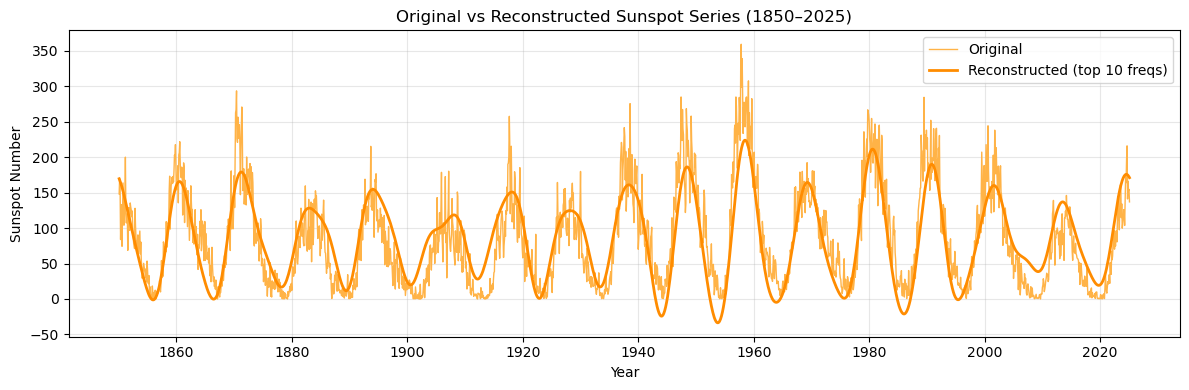

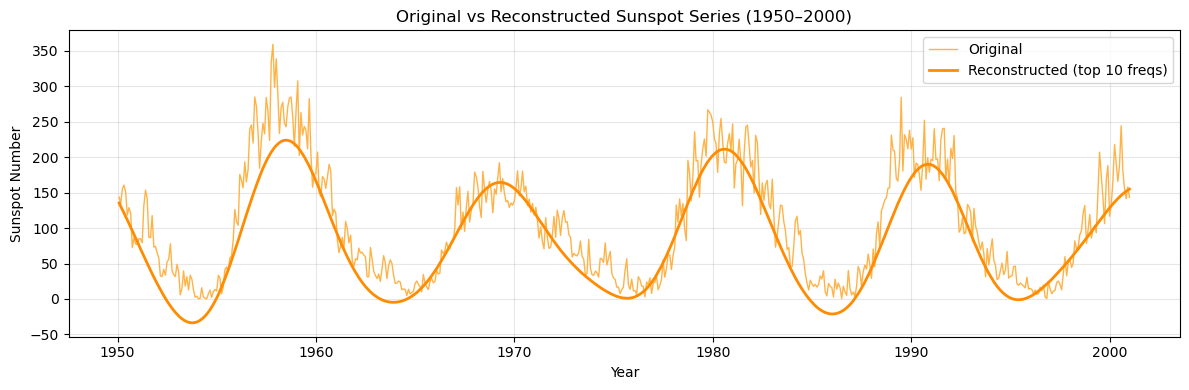

In [13]:
# Step 8: Plot original vs reconstructed series and save the figures

import matplotlib.pyplot as plt

orig_color = "#ffb347"    # lighter orange
recon_color = "#ff8c00"   # darker orange

# ---------- Full period ----------
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(ts_monthly.index, ts_monthly.values,
        color=orig_color, linewidth=1.0, label="Original")
ax.plot(ts_recon.index, ts_recon.values,
        color=recon_color, linewidth=2.0, label="Reconstructed (top 10 freqs)")
ax.set_title("Original vs Reconstructed Sunspot Series (1850–2025)")
ax.set_xlabel("Year")
ax.set_ylabel("Sunspot Number")
ax.grid(True, alpha=0.3)
ax.legend()

fig.tight_layout()
fig.savefig("sunspots_original_vs_recon_full.png", dpi=300)

# ---------- Zoomed 1950–2000 ----------
zoom_orig = ts_monthly["1950":"2000"]
zoom_recon = ts_recon["1950":"2000"]

fig2, ax2 = plt.subplots(figsize=(12, 4))
ax2.plot(zoom_orig.index, zoom_orig.values,
         color=orig_color, linewidth=1.0, label="Original")
ax2.plot(zoom_recon.index, zoom_recon.values,
         color=recon_color, linewidth=2.0, label="Reconstructed (top 10 freqs)")
ax2.set_title("Original vs Reconstructed Sunspot Series (1950–2000)")
ax2.set_xlabel("Year")
ax2.set_ylabel("Sunspot Number")
ax2.grid(True, alpha=0.3)
ax2.legend()

fig2.tight_layout()
fig2.savefig("sunspots_original_vs_recon_1950_2000.png", dpi=700)

plt.show()

### # Step 9: Quantify how good the reconstruction is

In [14]:
# Step 9: Quantify how good the reconstruction is

import numpy as np

# Helper function
def reconstruction_stats(orig, recon, label="full"):
    orig_vals = orig.values
    recon_vals = recon.values

    mse = np.mean((orig_vals - recon_vals) ** 2)
    var_orig = np.var(orig_vals)
    r2 = 1 - mse / var_orig
    corr = np.corrcoef(orig_vals, recon_vals)[0, 1]

    print(f"--- {label} period ---")
    print(f"MSE: {mse:.2f}")
    print(f"Variance of original: {var_orig:.2f}")
    print(f"Fraction of variance explained (R^2): {r2:.3f}")
    print(f"Correlation(original, recon): {corr:.3f}")
    print()

# Full period
reconstruction_stats(ts_monthly, ts_recon, label="1850–2025")

# 1950–2000 window
reconstruction_stats(ts_monthly["1950":"2000"],
                     ts_recon["1950":"2000"],
                     label="1950–2000")


--- 1850–2025 period ---
MSE: 1244.08
Variance of original: 4592.16
Fraction of variance explained (R^2): 0.729
Correlation(original, recon): 0.854

--- 1950–2000 period ---
MSE: 1473.37
Variance of original: 6149.01
Fraction of variance explained (R^2): 0.760
Correlation(original, recon): 0.922



In [15]:
### saving the results 
import numpy as np
import pandas as pd

# ---------- 1. Top-10 periodicities table (1–40 year band) ----------

K = 10  # number of dominant periods

idx_sorted = np.argsort(power_plot)[::-1]
top_idx = idx_sorted[:K]

top_periods = period_plot[top_idx]
top_powers = power_plot[top_idx]

df_periods = pd.DataFrame({
    "rank": np.arange(1, K + 1),
    "period_years": top_periods,
    "power": top_powers
})

df_periods.to_csv("sunspots_top_periodicities.csv", index=False)
print("Top periodicities table:")
print(df_periods, "\n")
print("Saved as 'sunspots_top_periodicities.csv'\n")

# ---------- 2. Reconstruction statistics table ----------

def compute_stats(orig, recon):
    orig_vals = orig.values
    recon_vals = recon.values
    mse = np.mean((orig_vals - recon_vals) ** 2)
    var_orig = np.var(orig_vals)
    r2 = 1 - mse / var_orig
    corr = np.corrcoef(orig_vals, recon_vals)[0, 1]
    return mse, var_orig, r2, corr

mse_full, var_full, r2_full, corr_full = compute_stats(ts_monthly, ts_recon)
mse_zoom, var_zoom, r2_zoom, corr_zoom = compute_stats(
    ts_monthly["1950":"2000"], ts_recon["1950":"2000"]
)

df_stats = pd.DataFrame([
    {
        "period": "1850–2025",
        "mse": mse_full,
        "variance_original": var_full,
        "r2": r2_full,
        "correlation": corr_full
    },
    {
        "period": "1950–2000",
        "mse": mse_zoom,
        "variance_original": var_zoom,
        "r2": r2_zoom,
        "correlation": corr_zoom
    }
])

df_stats.to_csv("sunspots_reconstruction_stats.csv", index=False)
print("Reconstruction statistics table:")
print(df_stats, "\n")
print("Saved as 'sunspots_reconstruction_stats.csv'")


Top periodicities table:
   rank  period_years         power
0     1     10.942708  4.597010e+09
1     2     10.299020  9.599978e+08
2     3     11.672222  5.765919e+08
3     4      9.726852  5.517608e+08
4     5     21.885417  1.571392e+08
5     6      8.754167  1.481224e+08
6     7      7.958333  1.388744e+08
7     8      5.471354  1.216414e+08
8     9     12.505952  7.192667e+07
9    10      8.337302  6.648496e+07 

Saved as 'sunspots_top_periodicities.csv'

Reconstruction statistics table:
      period         mse  variance_original        r2  correlation
0  1850–2025  1244.08113        4592.161273  0.729086     0.853865
1  1950–2000  1473.37459        6149.012169  0.760388     0.922452 

Saved as 'sunspots_reconstruction_stats.csv'


### # Step 10: Compute windowed FFT spectra for different time periods

In [16]:
# Step 10: Compute windowed FFT spectra for different time periods

import numpy as np

def fft_period_power(series, dt=1.0, period_min=1.0, period_max=40.0):
    """
    Compute period (years) vs power for a monthly time series.
    Returns (period_years, power) restricted to [period_min, period_max].
    """
    x = series.values.astype(float)
    N = len(x)
    x_demean = x - x.mean()

    # FFT
    X = np.fft.fft(x_demean)
    freqs = np.fft.fftfreq(N, d=dt)   # cycles per month

    # Positive freqs only
    positive = freqs > 0
    freqs_pos = freqs[positive]
    X_pos = X[positive]

    power = np.abs(X_pos) ** 2

    # Convert to cycles/year and to periods
    freqs_per_year = freqs_pos * 12.0
    period_years = 1.0 / freqs_per_year

    # Restrict to desired period range
    mask = (period_years >= period_min) & (period_years <= period_max)

    return period_years[mask], power[mask]

# Define windows
windows = [
    ("1850–1900", "1850", "1900"),
    ("1900–1950", "1900", "1950"),
    ("1950–2000", "1950", "2000"),
    ("2000–2025", "2000", "2025"),
]

window_spectra = {}

for label, start, end in windows:
    sub = ts_monthly[start:end]
    periods, pw = fft_period_power(sub)
    window_spectra[label] = (periods, pw)
    print(label, "-> months:", len(sub))

print("\nStored period-power spectra for windows:")
for label in window_spectra:
    p, pw = window_spectra[label]
    print(f"{label}: {len(p)} frequency points in 1–40 year band")


1850–1900 -> months: 612
1900–1950 -> months: 612
1950–2000 -> months: 612
2000–2025 -> months: 301

Stored period-power spectra for windows:
1850–1900: 50 frequency points in 1–40 year band
1900–1950: 50 frequency points in 1–40 year band
1950–2000: 50 frequency points in 1–40 year band
2000–2025: 25 frequency points in 1–40 year band


### # Step 11: Plot windowed spectra (one panel per historical period)

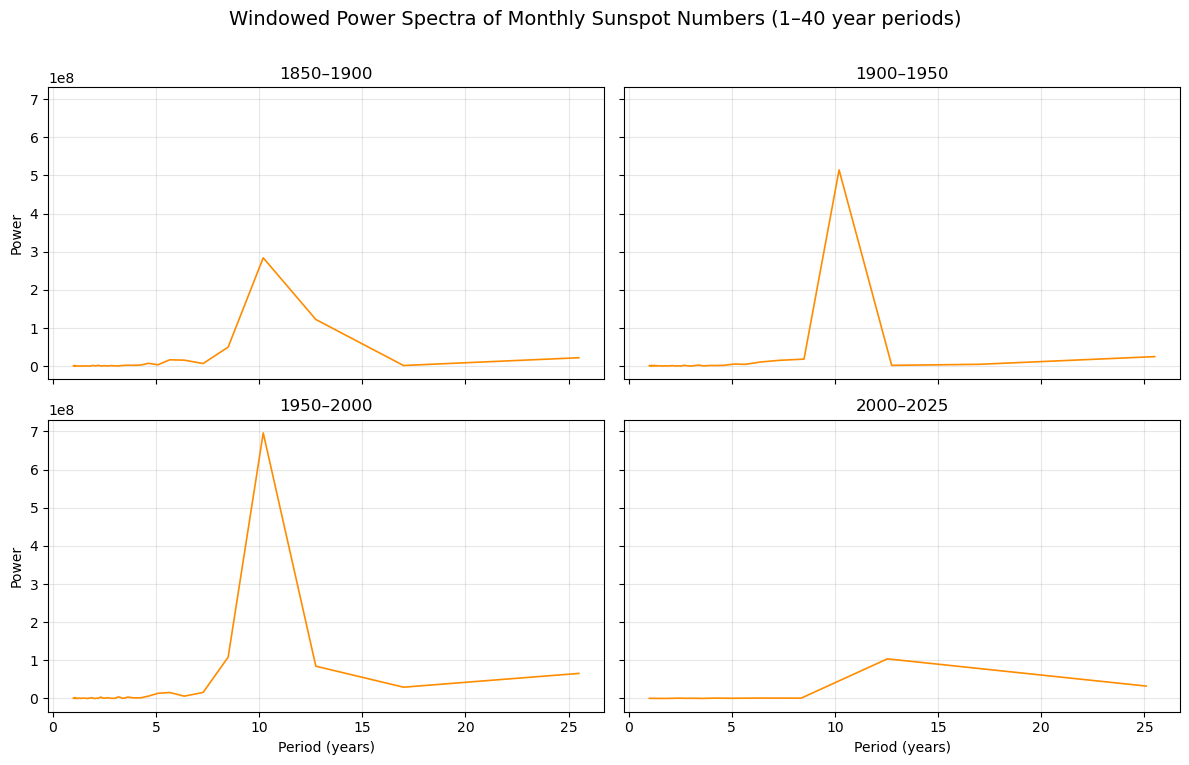

In [17]:
# Step 11: Plot windowed spectra (one panel per historical period)

import matplotlib.pyplot as plt

solar_color = "#ff8c00"

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.ravel()

for ax, (label, (periods, pw)) in zip(axes, window_spectra.items()):
    ax.plot(periods, pw, color=solar_color, linewidth=1.2)
    ax.set_title(label)
    ax.grid(True, alpha=0.3)
    ax.invert_xaxis()  # longer periods on the left

axes[2].set_xlabel("Period (years)")
axes[3].set_xlabel("Period (years)")
axes[0].set_ylabel("Power")
axes[2].set_ylabel("Power")

fig.suptitle("Windowed Power Spectra of Monthly Sunspot Numbers (1–40 year periods)",
             y=0.95, fontsize=14)

fig.tight_layout(rect=[0, 0, 1, 0.94])
fig.savefig("sunspots_windowed_spectra_1_40yrs.png", dpi=600)

plt.show()


### # Step 12: Sliding-window FFT (30-year windows, 5-year step)

In [18]:
# Step 12: Sliding-window FFT (30-year windows, 5-year step)

import numpy as np
import pandas as pd

# Window and step in months
window_years = 30
step_years = 5
window_len = window_years * 12   # 360 months
step_len = step_years * 12       # 60 months

values = ts_monthly.values.astype(float)
dates = ts_monthly.index
N_total = len(values)

print("Total monthly points:", N_total)
print("Window length (months):", window_len)
print("Step length (months):", step_len)

# --- Precompute frequency/period grid for a window of length window_len ---
dt = 1.0  # 1 month
freqs_all = np.fft.fftfreq(window_len, d=dt)      # cycles per month
positive = freqs_all > 0
freqs_pos = freqs_all[positive]
freqs_year = freqs_pos * 12.0                     # cycles per year
periods_all = 1.0 / freqs_year                    # years

# Restrict to 1–25 year periods
period_min, period_max = 1.0, 25.0
mask_band = (periods_all >= period_min) & (periods_all <= period_max)

periods_win = periods_all[mask_band]              # y-axis of spectrogram

# --- Slide the window and compute power spectra ---
spec_list = []
time_centers = []

start = 0
while start + window_len <= N_total:
    end = start + window_len
    xw = values[start:end]
    xw = xw - xw.mean()

    Xw = np.fft.fft(xw)
    Xw_pos = Xw[positive]
    power_w = np.abs(Xw_pos) ** 2

    spec_list.append(power_w[mask_band])

    # center time of the window
    center_idx = start + window_len // 2
    time_centers.append(dates[center_idx])

    start += step_len

spec_power = np.array(spec_list).T   # shape: [n_periods, n_windows]
times_win = np.array(time_centers)

print("Spectrogram shape (periods × windows):", spec_power.shape)
print("Number of periods in band:", len(periods_win))
print("Number of time windows:", len(times_win))
print("First/last window centers:", times_win[0], "->", times_win[-1])


Total monthly points: 2101
Window length (months): 360
Step length (months): 60
Spectrogram shape (periods × windows): (29, 30)
Number of periods in band: 29
Number of time windows: 30
First/last window centers: 1865-01-31 00:00:00 -> 2010-01-31 00:00:00


### # Step 13: Plot time–frequency spectrogram (30-year window, 5-year step)

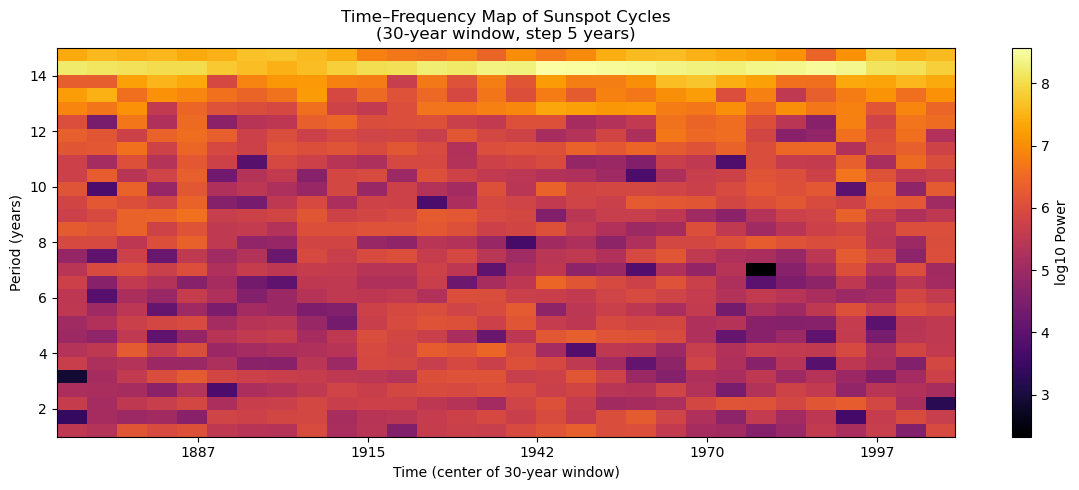

In [19]:
# Step 13: Plot time–frequency spectrogram (30-year window, 5-year step)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Use log10 power for better visibility
power_log = np.log10(spec_power + 1e-6)

# Periods are currently in descending order; flip to ascending for plotting
periods_plot = periods_win[::-1]
power_plot = power_log[::-1, :]   # flip rows to match

# Convert center times to matplotlib's numeric format
time_nums = mdates.date2num(times_win)

fig, ax = plt.subplots(figsize=(12, 5))

im = ax.imshow(
    power_plot,
    aspect='auto',
    origin='lower',
    extent=[time_nums[0], time_nums[-1], periods_plot[0], periods_plot[-1]],
    cmap='inferno'
)

ax.set_ylabel("Period (years)")
ax.set_xlabel("Time (center of 30-year window)")
ax.set_title("Time–Frequency Map of Sunspot Cycles\n(30-year window, step 5 years)")

# Format x-axis as years
date_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_fmt)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("log10 Power")

fig.tight_layout()
fig.savefig("sunspots_time_frequency_spectrogram_30yr_window.png", dpi=300)

plt.show()


### # Step 14: Extract dominant period per window (7–15 year band) and plot

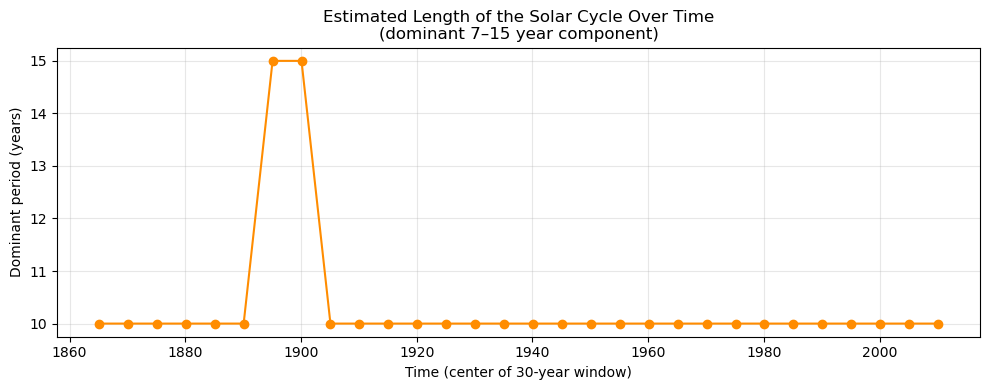

count    30.000000
mean     10.333333
std       1.268541
min      10.000000
25%      10.000000
50%      10.000000
75%      10.000000
max      15.000000
dtype: float64


In [20]:
# Step 14: Extract dominant period per window (7–15 year band) and plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# periods_win corresponds to original order used in spec_power (before flipping)
band_min, band_max = 7.0, 15.0
band_mask = (periods_win >= band_min) & (periods_win <= band_max)

dominant_periods = []
for w in range(spec_power.shape[1]):
    pw_band = spec_power[band_mask, w]
    per_band = periods_win[band_mask]
    idx_max = np.argmax(pw_band)
    dominant_periods.append(per_band[idx_max])

dom_series = pd.Series(dominant_periods, index=pd.to_datetime(times_win))

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dom_series.index, dom_series.values, marker="o", linestyle="-", color="#ff8c00")
ax.set_xlabel("Time (center of 30-year window)")
ax.set_ylabel("Dominant period (years)")
ax.set_title("Estimated Length of the Solar Cycle Over Time\n(dominant 7–15 year component)")

ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.tight_layout()
fig.savefig("sunspots_dominant_period_vs_time.png", dpi=300)

plt.show()

print(dom_series.describe())


In [ ]:
# Load daily data and convert to monthly means
df = pd.read_csv("daily_sunspots_time_series_1850-01_2025-01.csv")
df["date"] = pd.to_datetime(df["date"])
ts = df.set_index("date")["counts"].astype(float).resample("M").mean().dropna()

# Global FFT and power spectrum (1–40 year band)
x = ts.values - ts.values.mean(); N = len(x); X = np.fft.fft(x)
freqs = np.fft.fftfreq(N, d=1.0)            # cycles per month
mask_pos = freqs > 0
freqs_y = freqs[mask_pos] * 12.0           # cycles per year
periods = 1.0 / freqs_y                    # years per cycle
power = np.abs(X[mask_pos])**2
band = (periods >= 1.0) & (periods <= 40.0)
period_band = periods[band]
power_band = power[band]

# Reconstruct using K strongest frequencies in this band
K = 10; idx_sorted = np.argsort(power_band)[::-1][:K]
X_filt = np.zeros_like(X, dtype=complex)
for idx in idx_sorted:
    # map band index back to full FFT index (positive & negative frequency)
    k_pos = np.where(mask_pos)[0][band][idx]
    k_neg = N - k_pos
    X_filt[k_pos] = X[k_pos]
    X_filt[k_neg] = X[k_neg]
x_recon = np.fft.ifft(X_filt).real
ts_recon = pd.Series(x_recon + ts.values.mean(), index=ts.index)

# Windowed FFT (30-year window, 5-year step) for time–frequency map
win_len = 30 * 12           # months
step = 5 * 12; spec_list, centers = [], []
values = ts.values
dates = ts.index

for start in range(0, len(values) - win_len + 1, step):
    segment = values[start:start + win_len]
    seg_demean = segment - segment.mean()
    Xw = np.fft.fft(seg_demean)
    freqs_w = np.fft.fftfreq(win_len, d=1.0) * 12.0
    periods_w = 1.0 / freqs_w[1:win_len//2]       # drop zero freq
    power_w = np.abs(Xw[1:win_len//2])**2
    band_w = (periods_w >= 1.0) & (periods_w <= 25.0)
    spec_list.append(power_w[band_w])
    centers.append(dates[start + win_len//2])

spec_power = np.array(spec_list).T         # periods × windows